In [1]:
NAME = "Sam Hamers"
COLLABORATORS = "-"

|Name|SNR|ANR|
|----|---|----|
|Sam Hamers|2014708|u873371|

# Research question
Is economic growth harder to achieve for landlocked countries and what parameters cause this effect?

# Motivation
There are several potential causes for landlocked countries (LLC's) that prevent them from growing at the same rate as other countries that have harbors for ocean-access. The most important reasons are:
* High transport costs and import/export tariffs for using neighbouring countries' harbors
* This leads to higher costs of improving domestic infrastructure, which further increases transport costs, etc.
* Being highly dependent on another country for importing and exporting also makes you more susceptible to idiosyncratic shocks occurring in that country

Historically, relatively many landlocked countries have been grouped with the least-developed countries on the planet. About 22% of all countries is landlocked, Lahiri and Masjidi (2012) approximated that about 40% of the world's lowest income countries are landlocked using data from several years ago. Data from the United Nations from last year shows that this percentage is still very high, but lower at 36%. Furthermore, only 16% of the most developed countries is landlocked. This shows that landlocked countries are indeed overrepresented amongst low developed countries as neither percentage is particularly close to 22%, but that the situation is improving. (See 'Python Code' section for these calculations). 

Numerous papers conclude that landlocked countries have significantly lower economic development and growth. [MacKellar, Wörgötter and Wörz (2000)](https://www.researchgate.net/publication/5112526_Economic_Development_Problems_of_Landlocked_Countries) argue that average annual economic growth is 1.5% lower if the country is landlocked. Other papers come to a similar conclusion, see for example: [Faye, McArthur, Sachs and Snow (2004)](https://doi-org.tilburguniversity.idm.oclc.org/10.1080/14649880310001660201) and [Raballand (2003)](https://doi-org.tilburguniversity.idm.oclc.org/10.1057/palgrave.ces.8100031). 

However, data used in these papers is from twenty or more years ago. (Further) globalization has increased accessibility of landlocked countries. Trade-barriers are likely lower than decades ago. Additionally, import and export of non-tangible goods has increased drastically. For this type of goods, being landlocked is not a significant drawback. So, is it still true that economic growth is harder to achieve for landlocked countries?

# Method


# Data
Here I list the four datasets that I use in this assignment, the data-cleaning and application is performed later in the 'Python Code' section. 

The main dataframe with which I will execute the data analysis and finally apply the model consists of two seperate datasets:
* Worldbank data on real GDP per capita (1960-2019), using the wbdata API (with 'ny.gdp.pcap.pp.cd' as indicator).
* Dataset containing all 45 landlocked countries (self-made using public data). ([Link to dataset on GitHub](https://github.com/SamHamers/AEA_Assignment))

Additionally, I use a dataset to draw the world map. This dataset consists of vectors that outline each country, and is publicly available on [Natural Earth](https://www.naturalearthdata.com/). I use the data on a 1:110 million scale as higher precision data is unnecessary when drawing a map of the entire world.

Finally, I use Human Development Index (HDI) data of 1990 and 2019 from the United Nations, publicly available [here](http://hdr.undp.org/en/indicators/137506).

# Preview of the answers

# Main assumptions

# Python code
First install and import all required packages for the entire assignment. The first cell contains code for the installation of packages that allow for interactive plots, these are possibly not yet installed on your machine. Certain plots should display a slider to manipulate data in the plot. Remove the '#' to install the required packages. The second cell imports all packages. 

In [33]:
#%%bash

#pip install --user geopandas
#pip install --user bokeh
#pip install --user ipywidgets

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import wbdata as wb
import sys
#!{sys.executable} -m pip install --user geopandas
import geopandas as gpd
import json as json
from bokeh.io import output_notebook, show, curdoc, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import (GeoJSONDataSource, ColumnDataSource, CategoricalColorMapper, LinearColorMapper,
                         ContinuousColorMapper, ColorBar, HoverTool, FuncTickFormatter, NumeralTickFormatter,
                         SingleIntervalTicker, Slider, CustomJS, Legend, LegendItem)
from bokeh.palettes import brewer 
from bokeh.layouts import column, widgetbox
from bokeh.transform import factor_cmap
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
import statsmodels.formula.api as sm
#import sys
#!{sys.executable} -m pip install ipywidgets
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html
from scipy import optimize
from sympy import symbols, Eq, solve, solveset
output_notebook()

Loading BokehJS ...

In [5]:
#from IPython.display import YouTubeVideo
#YouTubeVideo("Z0qHA93oOSc")

First I create one large dataframe from three seperate datasources as explained in the 'data' section above. First, I import Worldbank data using the wbdata API and name it dfgdp_data:

In [38]:
#wb.search_indicators("country")
indicators = {"ny.gdp.pcap.pp.cd" : "gdp"} #I use GDP per capita, PPP (in current US dollars)
dfgdp_data = wb.get_dataframe(indicators, country="all").reset_index()
dfgdp_data.head()

,country,date,gdp
0,Arab World,2020,NaN
1,Arab World,2019,15256.376720
2,Arab World,2018,14985.352890
3,Arab World,2017,14562.367966
4,Arab World,2016,14025.865608


Next, I clean up the data and make sure that it matches with the other three datasets that will be used later:

In [39]:
#Define a dictionary to rename certain countries. Country names have to match across the three datasources to perform merges
rename = {"Congo, Dem. Rep.": "Democratic Republic of the Congo", "Congo, Rep.": "Republic of the Congo", "Cote d'Ivoire": "Ivory Coast", "Czech Republic": "Czechia",
          "Egypt, Arab Rep.": "Egypt", "Eswatini": "eSwatini", "Gambia, The": "Gambia", "Iran, Islamic Rep.": "Iran", "Korea, Rep.": "South Korea", "Kyrgyz Republic": "Kyrgyzstan",
          "Lao PDR": "Laos", "North Macedonia": "Macedonia", "Russian Federation": "Russia", "Serbia": "Republic of Serbia", "Slovak Republic": "Slovakia",
          "Syrian Arab Republic": "Syria", "Tanzania": "United Republic of Tanzania", "United States": "United States of America", "Venezuela, RB": "Venezuela", "Yemen, Rep.": "Yemen"}

dfgdp_data["country"] = dfgdp_data["country"].replace(rename) #Rename countries to match data
dfgdp_data["date"] = pd.to_numeric(dfgdp_data["date"], downcast="integer")
dfgdp_data.at[9150:9210, "country"] = "North Korea"
dfgdp_data = dfgdp_data.iloc[2867:,:] #Remove first 2867 rows from dataset. These contain regions, not countries

#Add rows for countries Palestine, Somaliland and Western Sahara which are not recognized by the Worldbank:
for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Palestine"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Somaliland"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i 

for i in np.arange(0,61): #Every country has 61 rows (years 1960 to 2020)
    dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
    dfgdp_data.loc[[len(dfgdp_data)-1], "country"] = "Western Sahara"
    dfgdp_data.loc[[len(dfgdp_data)-1], "date"] = 2020 - i


#Add log_gdp to dataframe
dfgdp_data["log_gdp"] = np.log(dfgdp_data["gdp"])
#Add growth_gdp and growth_log_gdp to dataframe
dfgdp_data["growth_gdp"] = (dfgdp_data["gdp"] - dfgdp_data["gdp"].shift(-1)) / dfgdp_data["gdp"].shift(-1)
dfgdp_data["growth_log_gdp"] = (dfgdp_data["log_gdp"] - dfgdp_data["log_gdp"].shift(-1)) / dfgdp_data["log_gdp"].shift(-1)

dfgdp_data["gdp_shift"] = dfgdp_data["gdp"].shift(-1)
dfgdp_data["log_gdp_shift"] = dfgdp_data["log_gdp"].shift(-1)

dfgdp_data.head()

#dfgdp_data.to_csv('Data/worldbank_data_gdp_per_capita_ppp.csv', sep = ";", decimal = ",")

<ipython-input-39-e9d9f0fc6598>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-39-e9d9f0fc6598>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True) #Add empty row at bottom of df
<ipython-input-39-e9d9f0fc6598>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfgdp_data = dfgdp_data.append(pd.Series(), ignore_index = True)


,country,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift
0,Afghanistan,2020.0,NaN,NaN,NaN,NaN,2156.419482,7.676204
1,Afghanistan,2019.0,2156.419482,7.676204,0.035087,0.004513,2083.321897,7.641719
2,Afghanistan,2018.0,2083.321897,7.641719,0.012115,0.001578,2058.383832,7.629676
3,Afghanistan,2017.0,2058.383832,7.629676,0.039004,0.005040,1981.112469,7.591414
4,Afghanistan,2016.0,1981.112469,7.591414,-0.050876,-0.006831,2087.305323,7.643629


Now I use the second datasource to create dflandlocked. This source contains all 45 countries that are landlocked. Then, I add a column to dfgdp_data. For countries that exist in dflandlocked, the value in this column equals 'True', otherwise the value is 'False'. dfgdp_data with this additional column is stored in dfgdp. 

In [49]:
dflandlocked = pd.read_csv("Data/landlocked.csv", sep = ";")
dflandlocked.head()

,Country,Continent
0,Afghanistan,Asia
1,Andorra,Europe
2,Armenia,Asia
3,Austria,Europe
4,Azerbaijan,Asia


In [43]:
#'Left-merge' two datasets. Use dfgdp_data and add column, when dataframes overlap, landlocked = True, otherwise landlocked = False
dfgdp = dfgdp_data.assign(landlocked = dfgdp_data["country"].isin(dflandlocked["Country"]).astype(bool)) 
dfgdp["landlocked"] = dfgdp["landlocked"].replace({True: "Yes", False: "No"})
dfgdp.head()

,country,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift,landlocked
0,Afghanistan,2020.0,NaN,NaN,NaN,NaN,2156.419482,7.676204,Yes
1,Afghanistan,2019.0,2156.419482,7.676204,0.035087,0.004513,2083.321897,7.641719,Yes
2,Afghanistan,2018.0,2083.321897,7.641719,0.012115,0.001578,2058.383832,7.629676,Yes
3,Afghanistan,2017.0,2058.383832,7.629676,0.039004,0.005040,1981.112469,7.591414,Yes
4,Afghanistan,2016.0,1981.112469,7.591414,-0.050876,-0.006831,2087.305323,7.643629,Yes


Lastly, I add the vector data for each country to allow for drawing a world map. The vector data is stored in the column 'geometry' of the dataframe worldmap. The geopandas (gpd) package is used to interpret this data as a worldmap. Then, worldmap is merged with dfgdp to create dfgdp_merged. 

Note: Whenever a world map has to be visualized I will use dfgdp_merged. For all other data analyses I will leave out the vector data and use the dfgdp dataframe.

In [53]:
worldmap = "Data/ne_110m_admin_0_countries.shp"
worldmap = gpd.read_file(worldmap)[["ADMIN", "ADM0_A3", "geometry"]]
worldmap.columns = ["country", "code", "geometry"]
worldmap.head()

,country,code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [54]:
#Remove Antarctica as there is no available gdp data, and it takes up a lot of space on the map
worldmap = worldmap.drop(worldmap.index[159]) 

dfgdp_merged = worldmap.merge(dfgdp, how="left", on="country")
dfgdp_merged.fillna("NaN", inplace = True)
dfgdp_merged.head()

,country,code,geometry,date,gdp,log_gdp,growth_gdp,growth_log_gdp,gdp_shift,log_gdp_shift,landlocked
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2020.0,NaN,NaN,NaN,NaN,14289.960502,9.567313,No
1,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2019.0,14289.960502,9.567313,0.007501,0.000782,14183.563896,9.559839,No
2,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2018.0,14183.563896,9.559839,0.056164,0.005749,13429.315918,9.505195,No
3,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2017.0,13429.315918,9.505195,0.063118,0.006481,12632.013532,9.443990,No
4,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2016.0,12632.013532,9.443990,0.017691,0.001860,12412.422182,9.426453,No


In [9]:
#pd.set_option("max_rows", None)
#worldmap

The very first image that I create is a worldmap that displays all landlocked countries. To create this plot, I use the bokeh package because it allows for zooming-in and the hovertool is useful for identifying individual countries. Furthermore, later I use the bokeh features to extend this plot with interactions. 

To plot a map with bokeh, the data needs to be formatted to geoJSON. Afterwards, I define the plot 'p' to create the world map.

In [65]:
#Dataframe contains 61 years of data. However, landlocked data does not (really) change over-time. So, pick an arbitrary year:
dfgdp_merged_2019 = dfgdp_merged[dfgdp_merged["date"] == 2019]
dfgdp_merged_2019_json = json.loads(dfgdp_merged_2019.to_json()) #Format to JSON
dfgdp_merged_2019_json_data = json.dumps(dfgdp_merged_2019_json)

#Create DataSource object which allows for bokeh features (like the hovertool)
map_datasource = GeoJSONDataSource(geojson = dfgdp_merged_2019_json_data)


p = figure(title = 'Landlocked Countries', plot_height = 600 , plot_width = 1000,
          tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None

#Set color_mapper to color country red when landlocked, and blue when not
color_mapper = CategoricalColorMapper(palette = ['red','blue'], factors = ("Yes", "No"), nan_color = "lightgrey")

#Add patches (the countries) to figure, color using the color_mapper. 
p.patches('xs','ys', source = map_datasource, fill_color = {'field' : 'landlocked', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)

#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('Landlocked', '@landlocked')])
p.add_tools(hover)

show(p)

The worldmap gives a great impression of the landlocked countries. Obviously, it says very little about development in these countries. The Human Development Index (HDI) is a measure developed by the United Nations that captures development in a comparible metric (comparable across countries for a given year, but not across years). I will use the HDI to give a quick insight in the overall development of landlocked countries compared to the other countries. First, I import the dataset as dfhdi and make it ready:

In [161]:
dfhdi = pd.read_csv('Data/HumanDevelopmentIndex.csv', sep = ',')
dfhdi.head()

,HDI Rank,Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 32
0,169,Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,...,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511,NaN
1,69,Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,...,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795,NaN
2,91,Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,...,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748,NaN
3,36,Andorra,..,..,..,..,..,..,..,..,...,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868,NaN
4,148,Angola,..,..,..,..,..,..,..,..,...,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581,NaN


In [162]:
#Again, I rename certain (in this case landlocked) countries so that they match with dflandlocked
rename = {"Bolivia (Plurinational State of)": "Bolivia", "Eswatini (Kingdom of)": "eSwatini", "Lao People's Democratic Republic": "Laos", "Moldova (Republic of)": "Moldova", "North Macedonia": "Macedonia", "Palestine State of": "Palestine", "Serbia": "Republic of Serbia"}

dfhdi["Country"] = dfhdi["Country"].str.strip() #Data has 'leading spaces'. Remove here
dfhdi["Country"] = dfhdi["Country"].replace(rename) #Rename countries so that they match dflandlocked
dfhdi = dfhdi[["HDI Rank", "Country", "2019"]] #Select relevant columns, only use year 2019
dfhdi = dfhdi.rename(columns = {"2019": "HDI"})
dfhdi = dfhdi.replace("..", np.nan)
dfhdi["HDI"] = pd.to_numeric(dfhdi["HDI"])

#2 countries missing data: San Marino and Vatican City
dfhdi = dfhdi.append(pd.Series(), ignore_index = "True") #Add empty row at bottom of df
dfhdi.loc[[len(dfhdi)-1], "Country"] = "San Marino"
dfhdi = dfhdi.append(pd.Series(), ignore_index = "True") #Add empty row at bottom of df
dfhdi.loc[[len(dfhdi)-1], "Country"] = "Vatican City"

#Keep data in dfhdi of countries that are landlocked and store in llchdi
llchdi = dfhdi[dfhdi["Country"].isin(dflandlocked["Country"])] 

#Sort by alphabet for displaying purposes
llchdi = llchdi.sort_values("Country")
#Print, but without index because the alphabetic sorting mixes up the order of the index
print(llchdi.to_string(index = False)) 

HDI Rank                  Country   HDI
     169              Afghanistan 0.511
      36                  Andorra 0.868
      81                  Armenia 0.776
      18                  Austria 0.922
      88               Azerbaijan 0.756
      53                  Belarus 0.823
     129                   Bhutan 0.654
     107                  Bolivia 0.718
     100                 Botswana 0.735
     182             Burkina Faso 0.452
     185                  Burundi 0.433
     188 Central African Republic 0.397
     187                     Chad 0.398
      27                  Czechia 0.900
     173                 Ethiopia 0.485
      40                  Hungary 0.854
      51               Kazakhstan 0.825
     120               Kyrgyzstan 0.697
     137                     Laos 0.613
     165                  Lesotho 0.527
      19            Liechtenstein 0.919
      23               Luxembourg 0.916
      82                Macedonia 0.774
     174                   Malawi 0.483


<ipython-input-162-681feee054fd>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfhdi = dfhdi.append(pd.Series(), ignore_index = "True") #Add empty row at bottom of df
<ipython-input-162-681feee054fd>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfhdi = dfhdi.append(pd.Series(), ignore_index = "True") #Add empty row at bottom of df


Above, you can see every landlocked country with its HDI score in 2019. As discussed earlier in the 'Motivation' section, relatively many landlocked countries are amongst the least developed countries. Least developed countries are defined as countries with an HDI below 0.55. Furthermore, the share of landlocked countries in the most developed countries (with an HDI over 0.8) is relatively low. These two ratios are defined and calculated as follows:

\begin{equation}
\textrm{% of least developed economies that is landlocked = }\frac{\textrm{# LLCs with HDI < 0.55}}{\textrm{Total # countries with HDI < 0.55}} * 100%
\end{equation}

\begin{equation}
\textrm{% of most developed economies that is landlocked = }\frac{\textrm{# LLCs with HDI > 0.8}}{\textrm{Total # countries with HDI > 0.8}} * 100%
\end{equation}

In [156]:
#Ratio of least developed countries that is landlocked:
percentage_leastdeveloped = len(llchdi[llchdi["HDI"] < 0.55])/len(dfhdi[dfhdi["HDI"] < 0.55])*100
print("Percentage of least developed economies that is landlocked: " + str(round(percentage_leastdeveloped, 2)) + "%")

#Ratio of most developed countries that is landlocked:
percentage_mostdeveloped = len(llchdi[llchdi["HDI"] > 0.8])/len(dfhdi[dfhdi["HDI"] > 0.8])*100
print("Percentage of most developed economies that is landlocked: " + str(round(percentage_mostdeveloped, 2)) + "%")

#General percentage of landlocked countries:
percentage_landlocked = len(llchdi)/len(dfhdi)*100
print("While the percentage of landlocked countries is " + str(round(percentage_landlocked, 2)) + "%")

Percentage of least developed economies that is landlocked: 36.11%
Percentage of most developed economies that is landlocked: 16.18%
While the percentage of landlocked countries is 21.63%


In [121]:
llchdi["lldc"] = np.where(llchdi["2019"] < 0.55, "Yes", "No")
llchdi = llchdi.rename(columns = {"Country": "country"})
dfgdp_llchdi = worldmap.merge(llchdi, how = "left", on = "country")

#Dataframe contains 61 years of data. However, landlocked data does not (really) change over-time. So, pick an arbitrary year:
#dfgdp_llchdi_2019 = dfgdp_merged[dfgdp_llchdi["date"] == 2019]
dfgdp_llchdi_2019_json = json.loads(dfgdp_llchdi.to_json()) #Format to JSON
dfgdp_llchdi_2019_json_data = json.dumps(dfgdp_llchdi_2019_json)

#Create DataSource object which allows for bokeh features (like the hovertool)
map_datasource2 = GeoJSONDataSource(geojson = dfgdp_llchdi_2019_json_data)

p = figure(title = 'Landlocked Countries', plot_height = 600 , plot_width = 1000,
          tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None

#Set color_mapper to color country red when landlocked, and blue when not
color_mapper = CategoricalColorMapper(palette = ['red','blue'], factors = ("Yes", "No"), nan_color = "lightgrey")

#Add patches (the countries) to figure, color using the color_mapper. 
p.patches('xs','ys', source = map_datasource2, fill_color = {'field' : 'lldc', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)

#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('Landlocked', '@least_developed')])
p.add_tools(hover)

show(p)
#dfgdp_llchdi.head(380)
#def data_slider(year):
#    dfgdp_selected_year = dfgdp[dfgdp["date"] == year]
#    dfgdp_merged_selected_year = worldmap.merge(dfgdp_selected_year, how="left", on="country")
#    dfgdp_merged_selected_year.fillna("NaN", inplace = True)
#    dfgdp_merged_selected_year_json = json.loads(dfgdp_merged_selected_year.to_json())
#    data_slider = json.dumps(dfgdp_merged_selected_year_json)
#    return data_slider

In [ ]:

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
#slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(Year = year_initial):
    #year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ ({})".format(Year)
    push_notebook()
#slider.on_change("value", callback)
#And add slider to plot p
#layout = column(widgetbox(slider), p)
#curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita', '$@gdp{0,0}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(p, notebook_handle = True)
slider = widgets.IntSlider(value = year_initial, min = 1990, max = 2019)
widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
def save_widgets ():
    display(
        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

In [13]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = dfgdp_merged_2015_json_data)
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#            '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper = color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ (2015)", plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP per capita', '$@gdp{0,0}'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [14]:
def data_slider(year):
    dfgdp_selected_year = dfgdp[dfgdp["date"] == year]
    dfgdp_merged_selected_year = worldmap.merge(dfgdp_selected_year, how="left", on="country")
    dfgdp_merged_selected_year.fillna("NaN", inplace = True)
    dfgdp_merged_selected_year_json = json.loads(dfgdp_merged_selected_year.to_json())
    data_slider = json.dumps(dfgdp_merged_selected_year_json)
    return data_slider

In [15]:
#To get output to HTML file use following in anaconda prompt:
#jupyter nbconvert --to html Documents\Python\AEA_Assignment_home.ipynb

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
#slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(Year = year_initial):
    #year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ ({})".format(Year)
    push_notebook()
#slider.on_change("value", callback)
#And add slider to plot p
#layout = column(widgetbox(slider), p)
#curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita', '$@gdp{0,0}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(p, notebook_handle = True)
slider = widgets.IntSlider(value = year_initial, min = 1990, max = 2019)
widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
def save_widgets ():
    display(
        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

interactive(children=(IntSlider(value=2019, description='Year', max=2019, min=1990), Output()), _dom_classes=(…

In [16]:
#To get output to HTML file use following in anaconda prompt:
#jupyter nbconvert --to html Documents\Python\AEA_Assignment_home.ipynb

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["RdYlGn"][10]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -0.15, high = 0.15, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 0.03)
formatter = NumeralTickFormatter(format = "0%")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#                '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter,
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita growth in % ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'growth_gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
#slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(Year = year_initial):
    #year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita growth in % ({})".format(Year)
    push_notebook()
#slider.on_change("value", callback)
#And add slider to plot p
#layout = column(widgetbox(slider), p)
#curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita growth', '@growth_gdp{0:3.1f%}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(p, notebook_handle = True)
slider = widgets.IntSlider(value = year_initial, min = 1991, max = 2019)
widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
def save_widgets ():
    display(
        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

interactive(children=(IntSlider(value=2019, description='Year', max=2019, min=1991), Output()), _dom_classes=(…

In [17]:
#Try using only Bokeh (no interactive plot)

#Initial year (default year that is selected by slider)
year_initial = 2019
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = data_slider(year_initial))
#Define a sequential multi-hue color palette.
palette = brewer["Greens"][9]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 45000, nan_color = "lightgrey")
#Define custom tick labels for color bar.
ticker_labels = SingleIntervalTicker(interval = 5000)
formatter = NumeralTickFormatter(format = "$0,")
#formatter = FuncTickFormatter(code = """
#    var data = {'0': '0$', '5000': '5,000$', '10000':'10,000$', '15000':'15,000$', '20000':'20,000$', '25000':'25,000$',
#                '30000':'30,000$','35000':'35,000$', '40000': '40,000$', '45000': '>45,000$'}
#    return data[tick]
#""")
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, ticker = ticker_labels, formatter = formatter, 
                     label_standoff = 5, width = 650, height = 22, location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = "GDP per capita in $ ({})".format(year_initial), plot_width = 1000, plot_height = 600, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")
#Remove both the x- and y-axis and the x- and y-lines from plot
p.axis.visible = False
p.grid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'gdp', 'transform' : color_mapper},
          line_color = 'gray', line_width = 0.75)
#Define slider
slider = Slider(title = "Year", start = 1990, end = 2015, value = year_initial) 
#Define callback function for slider to select different years
def callback(attr, new, old):
    year = slider.value
    geosource.geojson = data_slider(Year) #new_data = data_slider(year)
    #geosource.geojson = new_data
    p.title.text = "GDP per capita in $ (%year)"
    #push_notebook()
slider.on_change("value", callback)
#And add slider to plot p
layout = column(widgetbox(slider), p)
curdoc().add_root(layout)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'),
                            ('GDP per capita', '$@gdp{0,0}'),
                            ('Landlocked', '@landlocked')])
p.add_tools(hover)
#Display figure inline in Jupyter Notebook.

#Display figure.
show(layout)
#slider = widgets.IntSlider(value = year_initial, min = 1990, max = 2019)
#widgets.interact(callback, Year = slider)

#Save widget so that it appears after a kernal restart, slider does not update plot without rerunning this cell!!
#def save_widgets ():
#    display(
#        HTML('<script>Jupyter.menubar.actions._actions["widgets:save-widget"].handler()</script>'))
    
#embed_minimal_html('export.html', views=[slider], title='Widgets export')

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [18]:
dfgdp2019 = dfgdp[(dfgdp["date"] > 1989) & (dfgdp["date"] != 2020)]
meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == "Yes"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == "No"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()

meangdp_year = meangdp_year.merge(meangdp_year_landlocked, on = "date")
meangdp_year = meangdp_year.merge(meangdp_year_notlandlocked, on = "date")
meangdp_year.columns = ["date", "gdp_total", "gdp_total_growth", "gdp_landlocked", "gdp_landlocked_growth", "gdp_notlandlocked", "gdp_notlandlocked_growth"]
meangdp_year["gdp_total_growth_ma"] = (meangdp_year["gdp_total_growth"].shift(1) + meangdp_year["gdp_total_growth"] + meangdp_year["gdp_total_growth"].shift(-1)) / 3
meangdp_year["gdp_landlocked_growth_ma"] = (meangdp_year["gdp_landlocked_growth"].shift(1) + meangdp_year["gdp_landlocked_growth"] + meangdp_year["gdp_landlocked_growth"].shift(-1)) / 3
meangdp_year["gdp_notlandlocked_growth_ma"] = (meangdp_year["gdp_notlandlocked_growth"].shift(1) + meangdp_year["gdp_notlandlocked_growth"] + meangdp_year["gdp_notlandlocked_growth"].shift(-1)) / 3
meangdp_year.head()

#Melting likely not needed (different to R)
#meangdp_year = pd.melt(meangdp_year, id_vars = "date", value_name = "gdp")
#gdp_data["growth_gdp"] = (gdp_data["gdp"] - gdp_data["gdp"].shift(-1)) / gdp_data["gdp"].shift(-1)
#gdp_data["growth_log_gdp"] = (gdp_data["log_gdp"] - gdp_data["log_gdp"].shift(-1)) / gdp_data["log_gdp"].shift(-1)

#gdp_data["gdp_shift"] = gdp_data["gdp"].shift(-1)
#gdp_data["log_gdp_shift"] = gdp_data["log_gdp"].shift(-1)

<ipython-input-18-b9d53589f8e2>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year = dfgdp2019.groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-18-b9d53589f8e2>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_landlocked = dfgdp2019[dfgdp2019["landlocked"] == "Yes"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()
<ipython-input-18-b9d53589f8e2>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meangdp_year_notlandlocked = dfgdp2019[dfgdp2019["landlocked"] == "No"].groupby("date")["gdp", "growth_gdp"].mean().reset_index()


,date,gdp_total,gdp_total_growth,gdp_landlocked,gdp_landlocked_growth,gdp_notlandlocked,gdp_notlandlocked_growth,gdp_total_growth_ma,gdp_landlocked_growth_ma,gdp_notlandlocked_growth_ma
0,1990.0,7922.049764,NaN,4811.301531,NaN,8735.630071,NaN,NaN,NaN,NaN
1,1991.0,8175.676121,0.034260,5011.152381,0.020734,9021.159563,0.037797,NaN,NaN,NaN
2,1992.0,8346.153616,0.020990,4988.625297,-0.035797,9261.843158,0.036163,0.027101,-0.005468,0.035829
3,1993.0,8515.745296,0.026054,5034.005291,-0.001343,9451.138133,0.033526,0.024369,-0.016562,0.035374
4,1994.0,8742.844464,0.026061,5113.230439,-0.012546,9703.624647,0.036433,0.032830,0.007610,0.039630


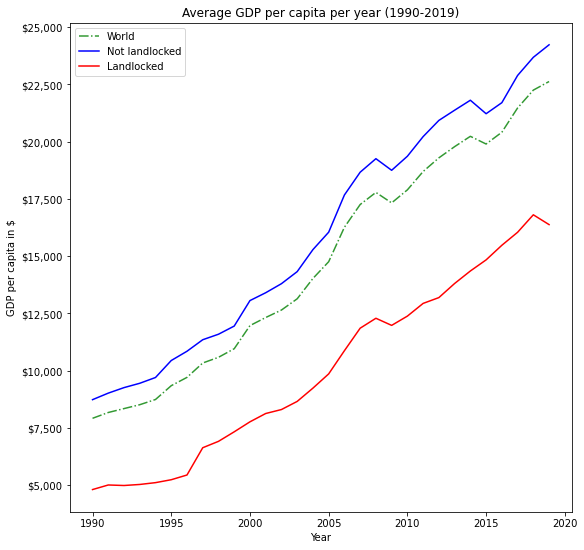

In [19]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total", data = meangdp_year, linestyle = "dashdot", color = "green", alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked", data = meangdp_year, color = "blue", label = "Not landlocked")
plt.plot("date", "gdp_landlocked", data = meangdp_year, color = "red", label = "Landlocked")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xlabel("Year")
plt.ylabel("GDP per capita in $")
plt.title("Average GDP per capita per year (1990-2019)")
plt.legend()

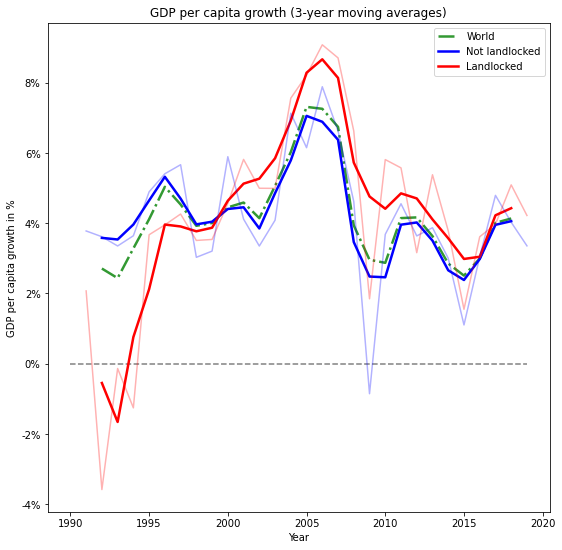

In [20]:
fig, ax = plt.subplots(1,1,figsize = (9,9))
plt.plot("date", "gdp_total_growth_ma", data = meangdp_year, linestyle = "dashdot", color = "green", linewidth = 2.5, alpha = 0.8, label = "World")
plt.plot("date", "gdp_notlandlocked_growth_ma", data = meangdp_year, color = "blue", linewidth = 2.5, label = "Not landlocked")
plt.plot("date", "gdp_landlocked_growth_ma", data = meangdp_year, color = "red", linewidth = 2.5, label = "Landlocked")
#plt.plot("date", "gdp_total_growth", data = meangdp_year, color = "green", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_notlandlocked_growth", data = meangdp_year, color = "blue", alpha = 0.3, label = "_nolegend_")
plt.plot("date", "gdp_landlocked_growth", data = meangdp_year, color = "red", alpha = 0.3, label = "_nolegend_")
plt.hlines(0, min(meangdp_year["date"]), max(meangdp_year["date"]), linestyle = "dashed", color = "gray")
ax.yaxis.set_major_formatter(ticker.FuncFormatter('{:,.0%}'.format))
plt.xlabel("Year")
plt.ylabel("GDP per capita growth in %")
plt.title("GDP per capita growth (3-year moving averages)")
plt.legend()

In [21]:
#Setting up a dataframe that only contains data of the years 1990 and 2019
df_1990_2019 = dfgdp[(dfgdp["date"] == 1990) | (dfgdp["date"] == 2019)]
df_1990_2019 = df_1990_2019.pivot(index = "country",
                                          columns = "date",
                                          values = ["log_gdp", "landlocked"]).reset_index()
df_1990_2019 = df_1990_2019.iloc[:,:-1]
df_1990_2019.columns = ["country", "log_gdp_1990", "log_gdp_2019", "landlocked"]
df_1990_2019["log_gdp_1990"] = pd.to_numeric(df_1990_2019["log_gdp_1990"], errors = "coerce")
df_1990_2019["log_gdp_2019"] = pd.to_numeric(df_1990_2019["log_gdp_2019"], errors = "coerce")
df_1990_2019["d_log_gdp"] = df_1990_2019["log_gdp_2019"] - df_1990_2019["log_gdp_1990"]

In [22]:
#Scatterplot to compare GDP per capita per country in 1990 with 2019
p = figure(title = "Comparison GDP per capita in $ (1990 - 2019)", x_range = (5.5,12), y_range = (5.5,12), 
           plot_width = 650, plot_height = 650, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")

#Making two seperate circle glyphs to allow for hiding datapoints upon click in legend
#Scatterplot with all landlocked countries
p.circle(x = "log_gdp_1990", y = "log_gdp_2019", source = df_1990_2019[df_1990_2019["landlocked"] == "Yes"],
             size = 7, fill_alpha = 0.6, color = "red", legend = "Yes")
#Add scatterplot with all other countries
p.circle(x = "log_gdp_1990", y = "log_gdp_2019", source = df_1990_2019[df_1990_2019["landlocked"] == "No"],
             size = 7, fill_alpha = 0.6, legend = "No")
p.ray(x = 5.5, y = 5.5, length = 0, angle = 45*np.pi/180, line_width = 2, color="black") #Adding 45 degree line to plot

p.xaxis.axis_label = "GDP per capita 1990"
p.yaxis.axis_label = "GDP per capita 2019"
p.legend.title = 'Landlocked (Click to disable)'
p.legend.location = "top_left"
p.legend.click_policy = "hide"
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country'), ('Landlocked', '@landlocked')])
p.add_tools(hover)
show(p)
#df_1990_2019.head()

In [23]:
#Execute similar OLS regression as the first one in the paper MacKellar, Wörgötter and Wörz (2000)
#Using 1990 as first (initial) date and 2019 as final date and one 'time period'

#Creating dataframe df_oneperiod1990 to execute OLS regression with
df_oneperiod1990 = df_1990_2019

#Executing first OLS regression
lm1_oneperiod1990 = sm.ols(formula="d_log_gdp ~ landlocked", data=df_oneperiod1990).fit()
print(lm1_oneperiod1990.summary())
#Result: No significant effect of being landlocked on GDP growth from 1990 to 2019

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.009598
Date:                Sun, 17 Jan 2021   Prob (F-statistic):              0.922
Time:                        15:03:09   Log-Likelihood:                -110.13
No. Observations:                 158   AIC:                             224.3
Df Residuals:                     156   BIC:                             230.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.1126      0.04

In [24]:
#Execute similar OLS regression as the second one in the paper MacKellar, Wörgötter and Wörz (2000) (adding log_gdp_1990)
#Using 1990 as first (initial) date and 2019 as final date and one 'time period'

#Executing second OLS regression
lm2_oneperiod1990 = sm.ols(formula="d_log_gdp ~ landlocked + log_gdp_1990", data=df_oneperiod1990).fit()
print(lm2_oneperiod1990.summary())

#Result: Still no significant effect of being landlocked on GDP growth from 1990 to 2019. Result of the addition of
#log_gdp_1990 is as expected; significant and negative (indicating 'beta convergence') just as in the paper. 

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.588
Date:                Sun, 17 Jan 2021   Prob (F-statistic):             0.0116
Time:                        15:03:09   Log-Likelihood:                -105.60
No. Observations:                 158   AIC:                             217.2
Df Residuals:                     155   BIC:                             226.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.9665      0.28

In [25]:
#Using 1997 as first (initial) date and 2019 as final date and one 'time period'
#1997 is chosen as the first year as this is the first year not researched in the paper by MacKellar, Wörgötter and Wörz
#(2000)

#Setting up a dataframe that only contains data of the years 1997 and 2019
df_1997_2019 = dfgdp[(dfgdp["date"] == 1997) | (dfgdp["date"] == 2019)]
df_1997_2019 = df_1997_2019.pivot(index = "country",
                                          columns = "date",
                                          values = ["log_gdp", "landlocked"]).reset_index()
df_1997_2019 = df_1997_2019.iloc[:,:-1]
df_1997_2019.columns = ["country", "log_gdp_1997", "log_gdp_2019", "landlocked"]
df_1997_2019["log_gdp_1997"] = pd.to_numeric(df_1997_2019["log_gdp_1997"], errors = "coerce")
df_1997_2019["log_gdp_2019"] = pd.to_numeric(df_1997_2019["log_gdp_2019"], errors = "coerce")
df_1997_2019["d_log_gdp"] = df_1997_2019["log_gdp_2019"] - df_1997_2019["log_gdp_1997"]

In [26]:
#creating dataframe df_oneperiod1997 to execute OLS regression with
df_oneperiod1997 = df_1997_2019

#Executing first OLS regression
lm1_oneperiod1997 = sm.ols(formula="d_log_gdp ~ landlocked", data=df_oneperiod1997).fit()
print(lm1_oneperiod1997.summary())

#Result: Significant effect (99%) of being landlocked on GDP growth from 1997 to 2019

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.420
Date:                Sun, 17 Jan 2021   Prob (F-statistic):            0.00712
Time:                        15:03:09   Log-Likelihood:                -91.261
No. Observations:                 173   AIC:                             186.5
Df Residuals:                     171   BIC:                             192.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8710      0.03

In [27]:
#Same regression as last one, but again adding log_gdp_1997 as well

#Executing second OLS regression
lm2_oneperiod1997 = sm.ols(formula="d_log_gdp ~ landlocked + log_gdp_1997", data=df_oneperiod1997).fit()
print(lm2_oneperiod1997.summary())

#Result: Still significant effect (99%) of being landlocked on GDP growth from 1997 to 2019. Lower estimate and lower
#significancy (still 99%). Adding the 'starting point' again leads to similar estimates as in the paper.

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     9.405
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           0.000134
Time:                        15:03:09   Log-Likelihood:                -85.857
No. Observations:                 173   AIC:                             177.7
Df Residuals:                     170   BIC:                             187.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.6429      0.23

In [28]:
#As the general argument is trade restrictions for landlocked countries, I'll remove EU member states (they have no/low
#tariffs etc.). These countries could raise GDP without having the negativities of being landlocked
eu_states = {"Luxembourg", "Czechia", "Austria", "Slovakia", "Hungary"} #Landlocked countries that are EU member states

#Using 1997 as first (initial) date and 2019 as final date and one 'time period' as this previously provided significant results

#Creating dataframe df_oneperiod1997_noeu that only contains data of the years 1997 and 2019 to execute OLS regression with
df_oneperiod1997_noeu = df_oneperiod1997[~df_oneperiod1997["country"].isin(eu_states)]

#Executing OLS regression
lmEU1_oneperiod1997 = sm.ols(formula="d_log_gdp ~ landlocked", data=df_oneperiod1997_noeu).fit()
print(lmEU1_oneperiod1997.summary())

#Result: Still significant effect (95%) of being landlocked on GDP growth from 1997 to 2019 when EU member states are
#removed. However, slightly lower estimate and slightly lower significancy (the EU states indeed increased the GDP of this
#group a little)

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     6.378
Date:                Sun, 17 Jan 2021   Prob (F-statistic):             0.0125
Time:                        15:03:09   Log-Likelihood:                -90.772
No. Observations:                 168   AIC:                             185.5
Df Residuals:                     166   BIC:                             191.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8710      0.03

In [29]:
#Same regression as last one, but again adding log_gdp_1997 as well

#Executing second OLS regression
lmEU2_oneperiod1997 = sm.ols(formula="d_log_gdp ~ landlocked + log_gdp_1997", data=df_oneperiod1997_noeu).fit()
print(lmEU2_oneperiod1997.summary())

#Result: No more significant effect of being landlocked on GDP growth from 1997 to 2019 when EU member states are
#removed. Lower estimate and lower significancy. Adding the 'starting point' again leads to similar estimates as in the paper.

                            OLS Regression Results                            
Dep. Variable:              d_log_gdp   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     9.211
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           0.000161
Time:                        15:03:09   Log-Likelihood:                -85.048
No. Observations:                 168   AIC:                             176.1
Df Residuals:                     165   BIC:                             185.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.7173      0.25

In [30]:
#First define all parameters. Then start without cooperation, this gives the Nash equilibrium (T_N,Px_N).

a = 10
b = 1
m = 1
n = 1
C = 200
N = 2
y = 1
Py = 2
rho = 0.8
#They find
#T_N = 0.117
#Px_N = 0.277

#def Px(P0,R): #Price with rents from country A
#    Px = P0*R
#    return Px

def Db(a,b,Px_N): #Demand for imports
    Db = a-b*Px_N
    return Db

def Y(y,La): #Production function of industry in country B
    Y = y*La
    return Y

def w(m,n,La): #Supply function of input from A to B
    w = m+n*La
    return w


#Country B will maximize profits of its domestic industry:
def profit_b_domestic(Py,y,La,m,n):
    profit_b_1 = Py*Y(y,La)-La*w(m,n,La)
    return profit_b_1

#La is determined endogenously, B chooses La to maximize domestic profits (without T)
La = optimize.fminbound(lambda La: -profit_b_domestic(Py,y,La,m,n),0,300,full_output = 0) #outcome = 0.5


#Welfare functions, three terms:
#Define profits of first term; Revenue for providing B access to harbor 
def profit_a_1(a,b,Px_N):
    profit_a_1 = Db(a,b,Px_N)*Px_N
    return profit_a_1
#Consumer surplus in B from consuming imported goods from A
def profit_b_1(a,b,Px_N):
    profit_b_1 = (Db(a,b,Px_N))**2/2*b
    return profit_b_1

#Define profits of second term:
#There are no profits for country A. Country B charges opportunity cost of trading through longer sea route to country A
def profit_b_2(N,C,T_N):
    profit_b_2 = N*C*(1-T_N)
    return profit_b_2

#Define profits of third term; Income of input owned by A and used in B:
def profit_a_3(La,T_N,m,n):
    profit_a_3 = La*(1+T_N)*(w(m,n,La)*(1+T_N))
    return profit_a_3
#Profits of domestic industry in B after subtracting payments made on input of A
def profit_b_3(La,T_N,Py,y,m,n):
    profit_b_3 = La*(1+T_N)*(Py*y-w(m,n,La)*(1+T_N))
    return profit_b_3

#A: Revenue for providing B access to harbor, Revenue of exports minus payment for using trade routes in B, Income of input owned by A and used in B
def Wa(a,b,Px_N,N,C,T_N,La,m,n):
    Wa = profit_a_1(a,b,Px_N)+(1000-profit_b_2(N,C,T_N))+profit_a_3(La,T_N,m,n)
    return Wa

#B: Cost of B for access to harbor of A, Revenue for giving access to trade routes in B,
#Profits of domestic industry in B after subtracting payments made on input of A
def Wb(a,b,Px_N,N,C,T_N,La,Py,y,m,n):
    Wb = profit_b_1(a,b,Px_N)+profit_b_2(N,C,T_N)+profit_b_3(La,T_N,Py,y,m,n)
    return Wb


#What is the optimal price Px that A can set (independent of T)? -> Px only depends on profit_a_1 and is endogenous!
#Px_N = optimize.fminbound(lambda Px: -profit_a_1(a,b,Px),0,300,full_output = 0) #outcome: Px = 5 (for all T!)
#Then what is the optimal T for country B, given Px = 5:
#T_N = optimize.fminbound(lambda T: -Wb(a,b,Px_N,N,C,T,La,Py,y,m,n),0,300,full_output = 0) #outcome: T = 0 (for Px = 5)
#So, the Nash equilibrium (no cooperation) is (T,Px) = (0,5). 

#What is the highest achievable TOTAL profits/welfare? (Set full cooperation, T = 1, Px = 0)
def total_profits(a,b,Px,N,C,T,La,m,n,Py,y):
    total_profits = Wa(a,b,Px,N,C,T,La,m,n)+Wb(a,b,Px,N,C,T,La,Py,y,m,n)
    return total_profits

maximize = lambda x: -total_profits(a,b,x[1],N,C,x[0],La,m,n,Py,y)   
result_total_profits = optimize.minimize(maximize, (0.1,0.5), bounds = ((0,1),(0,np.inf))) #Works but gives result that is unexpected. Could be right as it optimizes JOINT profit
#Without bounds, price (x[1]) becomes negative! Not viable (discuss in final product) (This is 'second best option')


#Currently, Px is endogenous, this is not reasonable as setting a lower Px will likely lead to a lower T,
#which is also good for country A (introduce game theory, ICC etc.)

#Now check case with (some) cooperation. What is the optimal combination of (T,Px) for BOTH countries? -> Equilibrium
#Deviating in one period, means punishment in all future periods
#Define outcome Wa and Wb in case of cooperation (C) and in case of deviation (D). When deviating, countries play NE:
def Wa_C(a,b,Px_C,N,C,T_C,La,m,n):
    Wa_C = profit_a_1(a,b,Px_C)+(1000-profit_b_2(N,C,T_C))+profit_a_3(La,T_C,m,n)
    return Wa_C

def Wa_D(a,b,Px_N,N,C,T_C,La,m,n):
    Wa_D = profit_a_1(a,b,Px_N)+(1000-profit_b_2(N,C,T_C))+profit_a_3(La,T_C,m,n)
    return Wa_D

def Wb_C(a,b,Px_C,N,C,T_C,La,Py,y,m,n):
    Wb_C = profit_b_1(a,b,Px_C)+profit_b_2(N,C,T_C)+profit_b_3(La,T_C,Py,y,m,n)
    return Wb_C

def Wb_D(a,b,Px_C,N,C,T_N,La,Py,y,m,n):
    Wb_D = profit_b_1(a,b,Px_C)+profit_b_2(N,C,T_N)+profit_b_3(La,T_N,Py,y,m,n)
    return Wb_D

#Then create ICC's (see paper)
def ICCa_D(a,b,Px_N,Px_C,N,C,T_C,La,m,n):
    ICCa_D = Wa_D(a,b,Px_N,N,C,T_C,La,m,n)-Wa_C(a,b,Px_C,N,C,T_C,La,m,n)
    return ICCa_D

def ICCa_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,m,n,rho):
    ICCa_C = (rho/(1-rho))*(Wa_C(a,b,Px_C,N,C,T_C,La,m,n)-Wa(a,b,Px_N,N,C,T_N,La,m,n))
    return ICCa_C

def ICCb_D(a,b,Px_C,N,C,T_N,T_C,La,Py,y,m,n):
    ICCb_D = Wb_D(a,b,Px_C,N,C,T_N,La,Py,y,m,n)-Wa_C(a,b,Px_C,N,C,T_C,La,m,n)
    return ICCb_D

def ICCb_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,Py,y,m,n,rho):
    ICCb_C = (rho/(1-rho))*(Wb_C(a,b,Px_C,N,C,T_C,La,Py,y,m,n)-Wb(a,b,Px_N,N,C,T_N,La,Py,y,m,n))
    return ICCb_C



#Equation (written) is: ICCa_D <= ICCa_C. Rewrite to get = 0:
#def ICCa(a,b,Px_N,Px_C,N,C,T_N,T_C,La,m,n,rho):
#    ICCa = ICCa_D(a,b,Px_N,Px_C,N,C,T_C,La,m,n)-ICCa_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,m,n,rho)
#    return ICCa

T_C, Px_C = symbols("T_C Px_C", real = True)
eq_a = Eq(ICCa_D(a,b,Px_N,Px_C,N,C,T_C,La,m,n)-ICCa_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,m,n,rho), 0)
eq_b = Eq(ICCb_D(a,b,Px_C,N,C,T_N,T_C,La,Py,y,m,n)-ICCb_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,Py,y,m,n,rho), 0)
cooperation = solve((eq_a,eq_b), (T_C, Px_C), dict = True)

print(profit_a_1(a,b,Px_N))
print(profit_b_2(N,C,T_N))
print(profit_a_3(La,T_N,m,n))

print(Wa(a,b,Px_N,N,C,T_N,La,m,n))
print(Wb(a,b,Px_N,N,C,T_N,La,Py,y,m,n))

print(result_total_profits.x)

print(eq_a)
print(eq_b)
print(cooperation)
#print(profit_b_domestic(Py,y,La,m,n))

NameError: name 'Px_N' is not defined

In [ ]:
x_range = np.arange(0,1.1,0.1)
test = ICCa_D(a,b,Px_N,Px_C,N,C,T_C,La,m,n)-ICCa_C(a,b,Px_N,Px_C,N,C,T_N,T_C,La,m,n,rho)
plt.plot(x_range, (list(test) for T_C in x_range))

In [ ]:
#Likely not included in final product! Results hard to interpret, likely lower std for landlocked?!
stdgdp_landlocked = dfgdp[dfgdp["landlocked"] == "Yes"].groupby(["country"], as_index = False)["gdp"].std()
stdgdp_notlandlocked = dfgdp[dfgdp["landlocked"] == "No"].groupby(["country"], as_index = False)["gdp"].std()

#Scatterplot to compare standard deviation of GDP of landlocked countries with not landlocked countries
p = figure(title = "Comparison of variation in GDP per capita", #x_range = (5.5,12), y_range = (5.5,12), 
           plot_width = 650, plot_height = 650, 
           tools = "pan, wheel_zoom, zoom_in, zoom_out, reset", active_scroll = "wheel_zoom", toolbar_location = "right")

#Making two seperate circle glyphs to allow for hiding datapoints upon click in legend
#Scatterplot with all landlocked countries
p.circle(x = "index", y = "gdp", source = stdgdp_landlocked,
             size = 7, fill_alpha = 0.6, color = "red", legend = "Yes")
#Add scatterplot with all other countries
p.circle(x = "index", y = "gdp", source = stdgdp_notlandlocked,
             size = 7, fill_alpha = 0.6, color = "blue", legend = "No")

p.xaxis.axis_label = "Index"
p.yaxis.axis_label = "Standard deviation"
p.legend.title = 'Landlocked (Click to disable)'
p.legend.location = "top_left"
p.legend.click_policy = "hide"
#Add hovertool
hover = HoverTool(tooltips=[('Country', '@country')])
p.add_tools(hover)
show(p)
#df_1990_2019.head()


#stdgdp_landlocked
#dfgdp.head()